In [1]:
from io import StringIO
import requests
import json
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_data_1 = pd.read_csv('/home/anirban/Downloads/DCOILBRENTEU_11Oct.csv')
df_data_1.head()

,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [4]:
len(df_data_1)

1305

Data Source
-----------
U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

In [3]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print(df_data_1.shape)

(8474, 2)


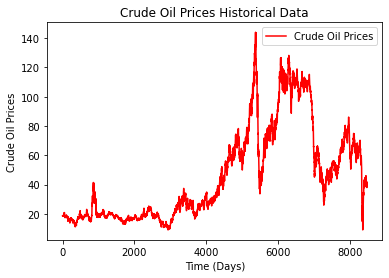

In [4]:
df_data_1_plot = df_data_1.iloc[:,1:2].values.astype(float)
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

Stateful vs. Stateless LSTM
--------------------------

1. **Stateless**: LSTM updates parameters on **batch 1** and then initiates cell states (meaning - memory, usually with zeros) for **batch 2** 
2. **Stateful**: it uses batch 1 last output cell sates as initial states for batch 2.

When to use which?
----------------

- When  sequences in batches are related to each other (e.g. prices of one commodity), we should better use **stateful** mode
- Else, when one sequence represents a complete sentence, we  should go with **stateless** mode




Batch-size: which batch-size to choose?
------------------------------------

**Very important decision!**

Imagine, you must learn to recognize a bird...
You are presented images of different birds.

What would you prefer:
1. To see the one image at a time, make your notes about special bird quilities (set your **weights**) and then see another bird and so on
2. **OR** may be you would better learn if you see - let's say 5 - bird images at ones. May be then you can faster notice the bird's intrinsic properties?

I'd say - the second method is more efficient for humans. We need more examples of an entitiy, that we have to distinguish. 

**So the machines! Therefore we select a batch size of 64.
Later in programming assigment we will see how the batch size impacts the prediction accuracy.**

In [5]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120
timesteps = 30

Batch-size and trainings-set size
-------------------------------

With **stateful LSTMs** the trainings-set size must be divisible without remainder by the batch-size (modulo = 0)

In [6]:
length = len(df_data_1)
print(length)
length *= 1 - 0.1
print(length)

8474
7626.6


In [7]:
7004.7%64.0

28.699999999999818

In [8]:
6976.0%64.0

0.0

In [9]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            #print(x)
    return (max(train_length_values))

In [10]:
length = get_train_length(df_data_1, batch_size, 0.1)
print(length)

7616


In [11]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.iloc[:,1:2].values
training_set.shape

(7676, 1)

In [12]:
# Feature Scaling
#scale between 0 and 1. the weights are esier to find.

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(7676, 1)

In [13]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len(y_train))
#create X_train matrix
#30 items per array (timestep) 
print(X_train[0:2])
print(np.array(X_train).shape)
#create Y_train matrix
#30 items per array (timestep) 
print(y_train[0:2])
print(np.array(y_train).shape)

7646
7616
7616
[array([0.07067112, 0.0693363 , 0.07007786, 0.07044865, 0.07067112,
       0.07044865, 0.07044865, 0.07030033, 0.07081943, 0.0710419 ,
       0.07156099, 0.07178346, 0.07081943, 0.07156099, 0.07178346,
       0.07178346, 0.0710419 , 0.07178346, 0.07267334, 0.07363737,
       0.07378569, 0.07378569, 0.07415647, 0.07267334, 0.07156099,
       0.07119021, 0.07400816, 0.07452725, 0.07400816, 0.07326659]), array([0.0693363 , 0.07007786, 0.07044865, 0.07067112, 0.07044865,
       0.07044865, 0.07030033, 0.07081943, 0.0710419 , 0.07156099,
       0.07178346, 0.07081943, 0.07156099, 0.07178346, 0.07178346,
       0.0710419 , 0.07178346, 0.07267334, 0.07363737, 0.07378569,
       0.07378569, 0.07415647, 0.07267334, 0.07156099, 0.07119021,
       0.07400816, 0.07452725, 0.07400816, 0.07326659, 0.07526882])]
(7616, 30)
[array([0.07526882, 0.07586207, 0.07697442, 0.07712273, 0.07697442,
       0.07845755, 0.07882833, 0.07956989, 0.07994067, 0.08290693,
       0.08379681, 0.08550241,

In [14]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)


(7616, 30, 1)
(7616, 30, 1)


In [15]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = tf.keras.layers.Input(batch_shape=(batch_size,timesteps,1))
#each layer is the input of the next layer
lstm_1_mae = tf.keras.layers.LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = tf.keras.layers.LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = tf.keras.layers.Dense(units = 1)(lstm_2_mae)

regressor_mae = tf.keras.Model(inputs=inputs_1_mae, outputs = output_1_mae)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 30, 1)]             0         
_________________________________________________________________
lstm (LSTM)                  (64, 30, 10)              480       
_________________________________________________________________
lstm_1 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense (Dense)                (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


Citation from Redwood Center for Theoretical Neuroscince (Berkeley University)
---------------------
http://redwood.berkeley.edu

http://redwood.berkeley.edu/vs265/Brian-Cheung-LSTMS.pdf

Overall LSTM Structure
----------------
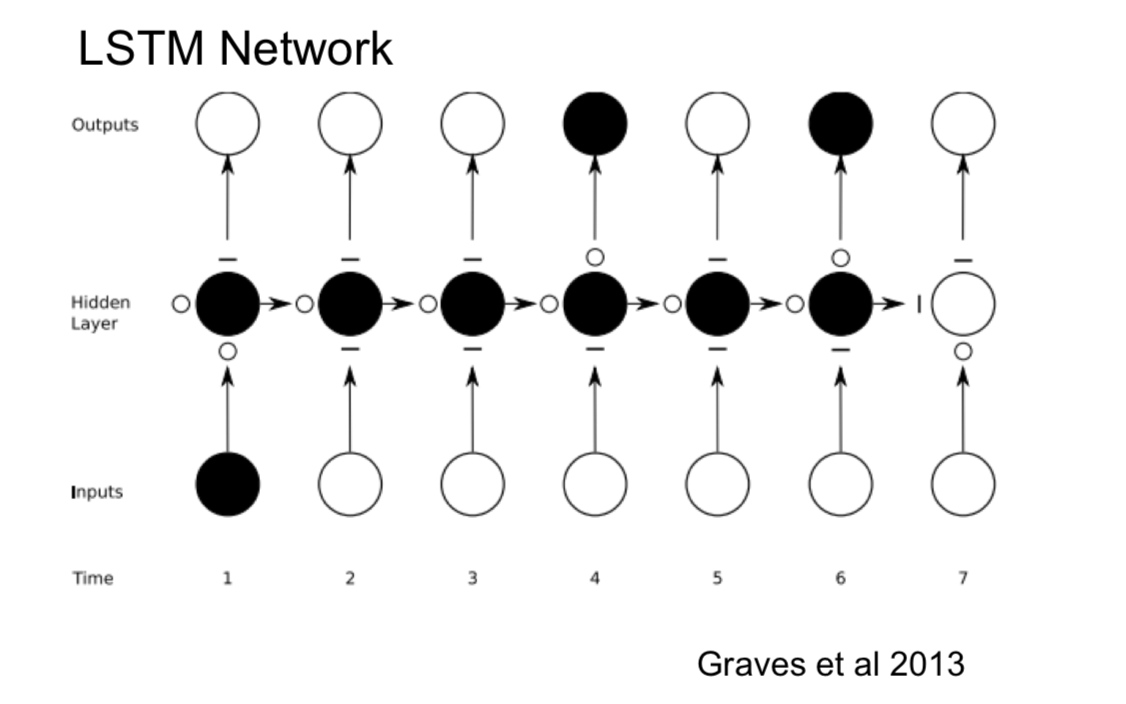


LSTM Node Anatomy
----------------
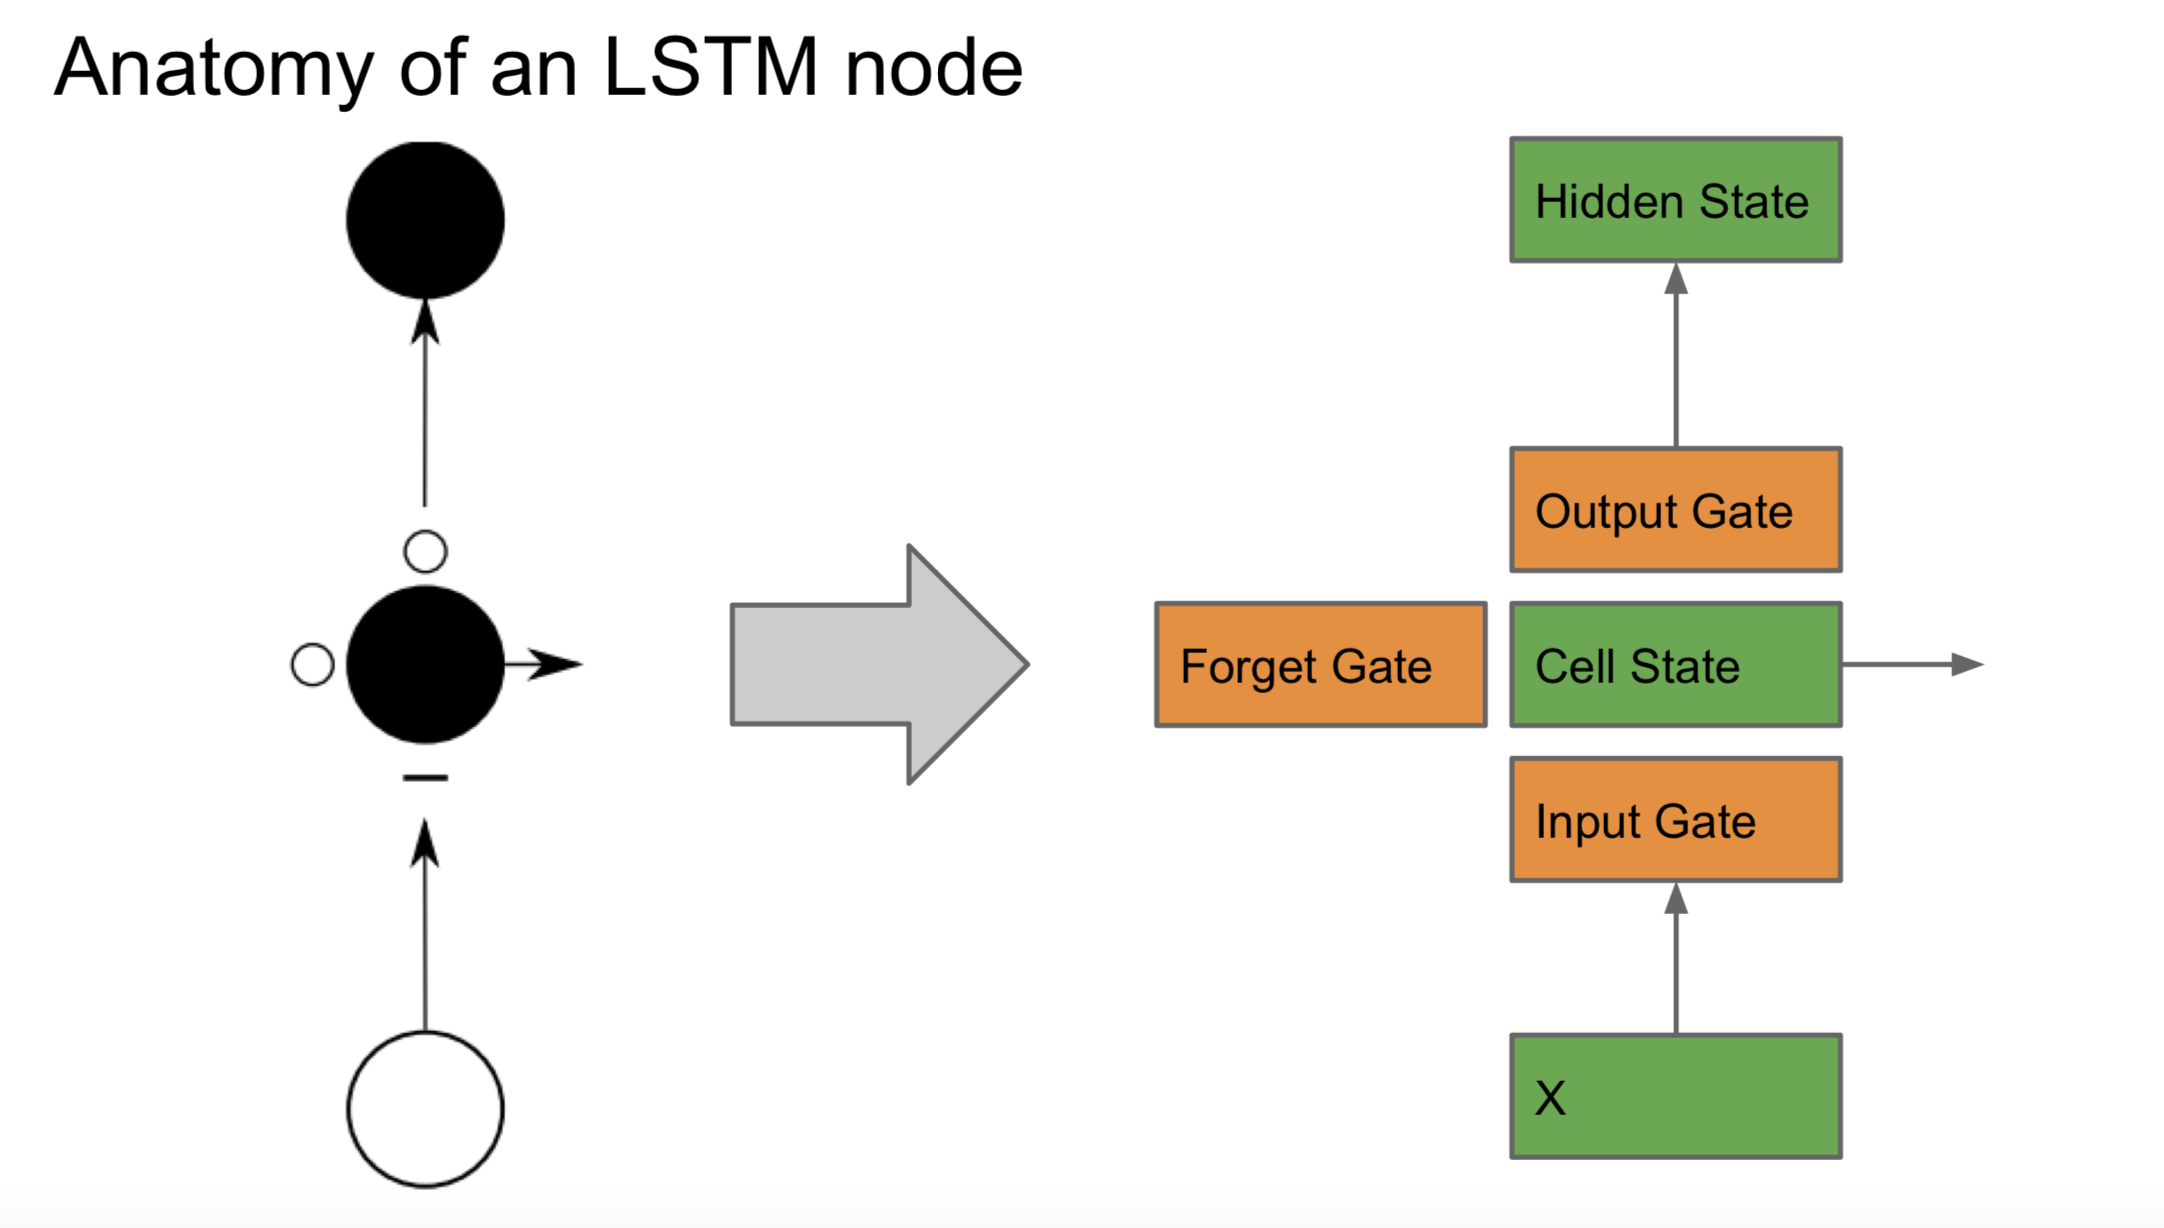

One of the best articles:
-----------------------
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

How LSTM Param Number is computed?
--------------------------------

1. To decide how to handle the memory each LSTM Cell has <bold>3 Gates</bold>: 
    - input (what to let in), 
    - forget (what to forget) and 
    - output (what to write to the output)
2. LSTM **Cell State** is its **memory**
3. LSTM Hidden State is equivalent to the Cell output:
    - lstm_hidden_state_size (number of neurons = memory cells) = lstm_outputs_size
4. Parameters:
    - weights for the inputs (lstm_inputs_size)
    - weights for the outputs (lstm_outputs_size)
    - bias variable
5.  Result from previous point - for all 3 Gates and for Cell State ( = 4)  
   
    \begin{equation}
          \textbf{PARAMETERS} = \textbf4 \times \textbf{ LSTM outputs size} \times (\textbf{weights LSTM inputs size} + \textbf{weights LSTM outputs size} + 1 \textbf{ bias variable})
    \end{equation}
    



In [21]:
# 1st LSTM Layer
parameters = 4 * 10 * (1 + 10 + 1)
print(parameters)

480


In [25]:
parameters = 4 * 10 * (10 + 10 + 1)
print(parameters)

840


In [ ]:
#Statefull

for i in range(epochs):
    #print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size, verbose=0)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()
    
#Stateless
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size,verbose=0)

In [106]:
#save model
regressor_mae.save(filepath="my_model_with_mae_30_ts.h5")

In [108]:
#load model
regressor_mae = tf.keras.models.load_model(filepath="my_model_with_mae_30_ts.h5")

In [109]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [110]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

1084
1148
1212
1212
64


In [111]:
print(upper_train, upper_test, len(df_data_1))

1148 1272 1279


In [27]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [112]:
X_test.shape

(64, 30, 1)

In [113]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)
print(predicted_bcg_values_test_mae.shape)




(64, 30, 1)
(64, 30)


In [114]:
testset_length

64

In [115]:
#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(34, 1)


In [75]:
len(test_set[-34:])

34

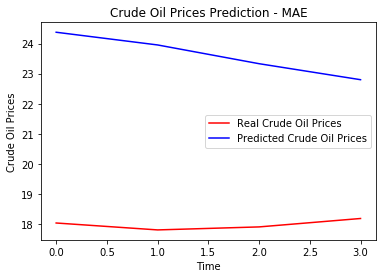

In [116]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [117]:
test_set[-34:]

array([['18.83'],
       ['18.88'],
       ['18.55'],
       ['18.60'],
       ['18.70'],
       ['18.58'],
       ['18.18'],
       ['18.23'],
       ['18.53'],
       ['18.60'],
       ['18.55'],
       ['18.65'],
       ['18.45'],
       ['18.70'],
       ['18.98'],
       ['18.88'],
       ['18.95'],
       ['18.65'],
       ['18.70'],
       ['18.53'],
       ['18.80'],
       ['18.73'],
       ['18.63'],
       ['18.50'],
       ['18.48'],
       ['18.53'],
       ['18.68'],
       ['18.48'],
       ['18.63'],
       ['18.63'],
       ['18.58'],
       ['18.48'],
       ['18.80'],
       ['18.85']], dtype=object)

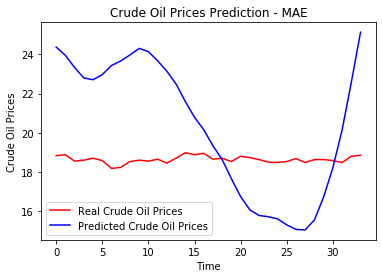

In [118]:
# Visualising the results
plt.plot(test_set[-34:].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test.astype(float), color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [119]:
#MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

5.677631258954829


In [120]:
#MAE (mean absolut error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

5.63671012878418


In [85]:
# Initialising the LSTM Model with MSE Loss Function

inputs_1_mse = tf.keras.layers.Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = tf.keras.layers.LSTM(10, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = tf.keras.layers.LSTM(10, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = tf.keras.layers.Dense(units = 1)(lstm_2_mse)

regressor_mse = tf.keras.Model(inputs=inputs_1_mse, outputs = output_1_mse)

#mse -> mean squared error as loss function
regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 30, 1)]             0         
_________________________________________________________________
lstm_4 (LSTM)                (64, 30, 10)              480       
_________________________________________________________________
lstm_5 (LSTM)                (64, 30, 10)              840       
_________________________________________________________________
dense_2 (Dense)              (64, 30, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [86]:
epochs = 120
for i in range(epochs):
    #print("Epoch: " + str(i))
    regressor_mse.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size, verbose=0)
    regressor_mse.reset_states()

In [87]:
regressor_mse.save(filepath="my_model_with_mse_30_ts.h5")

In [91]:
regressor_mse = tf.keras.models.load_model(filepath="my_model_with_mse_30_ts.h5")

In [92]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

In [93]:
pred_mse.shape

(34, 1)

In [94]:
test_set.shape

(124, 1)

In [95]:
timesteps

30

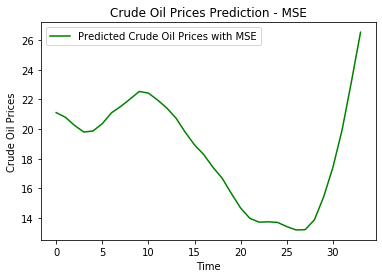

In [98]:
# Visualising the results
#plt.plot(test_set[timesteps:len(pred_mse)].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(pred_mse, color = 'green', label = 'Predicted Crude Oil Prices with MSE')
plt.title('Crude Oil Prices Prediction - MSE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [102]:
data_test = np.array(data[-34:])

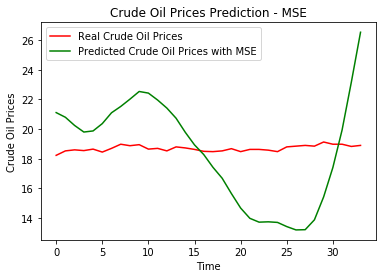

In [103]:
# Visualising the results
plt.plot(data_test.astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(pred_mse, color = 'green', label = 'Predicted Crude Oil Prices with MSE')
plt.title('Crude Oil Prices Prediction - MSE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps]))
print(rmse)

2.7845340781615557


In [42]:
mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print(mean)

48.153965517241375


In [43]:
rmse/mean * 100

5.782564422787906

In [44]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps])
print(mae)

2.382008031253157


In [45]:
mae/mean * 100

4.946649784014748